### The below code contains determining the AutoRegressive(p) and Moving average(q) terms to use in the ARIMA model to forecast current prices. The values calculated are used in the main file analysing the airbnb and zillow data

In [124]:
import numpy 
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [125]:
zillowtemp = zillow[zillow['City']=='New York']
zillowtemp = zillowtemp.iloc[:,np.r_[1,2,6,7:zillowtemp.shape[1]-1]]
tempdf = pd.DataFrame({"Date":list(zillowtemp.columns[3:].values),"Price":zillowtemp.iloc[0,3:]})
tempdf = tempdf.reset_index(drop = True)
tempdf.dropna(axis = 0,inplace=True)
tempdf['Date'] = pd.to_datetime(tempdf['Date'])
tempdf.set_index('Date', inplace=True)
tempts = tempdf['Price']

In [126]:
tempts = tempts.astype('float64')

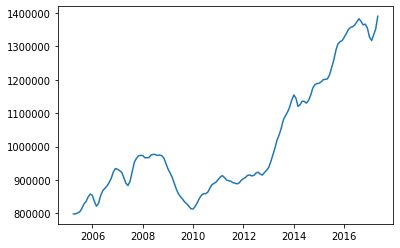

In [127]:
plt.plot(tempts);

In [128]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

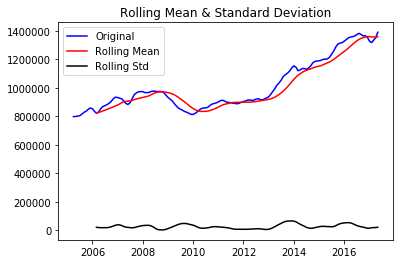

Results of Dickey-Fuller Test:
Test Statistic                   1.463389
p-value                          0.997384
#Lags Used                      14.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [129]:
test_stationarity(tempts)

This is not stationary because :
- Mean is increasing even though the std is small.
- Test stat is > critical value.
- Note: the signed values are compared and the absolute values.

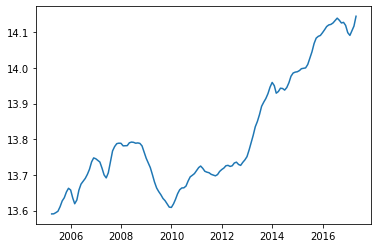

In [130]:
# transforming to reduce the trend
tempts_log = numpy.log(tempts)
plt.plot(tempts_log);

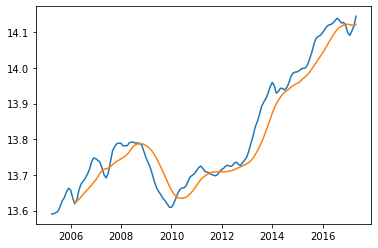

In [131]:
# using MA to model the trend 
moving_avg = tempts_log.rolling(12).mean()
plt.plot(tempts_log)
plt.plot(moving_avg);

In [132]:
#subtract the rolling mean from the original series
moving_avg_tempts_log_diff = tempts_log - moving_avg
moving_avg_tempts_log_diff.head(12)

Date
2005-04-01        NaN
2005-05-01        NaN
2005-06-01        NaN
2005-07-01        NaN
2005-08-01        NaN
2005-09-01        NaN
2005-10-01        NaN
2005-11-01        NaN
2005-12-01        NaN
2006-01-01        NaN
2006-02-01        NaN
2006-03-01   -0.00372
Name: Price, dtype: float64

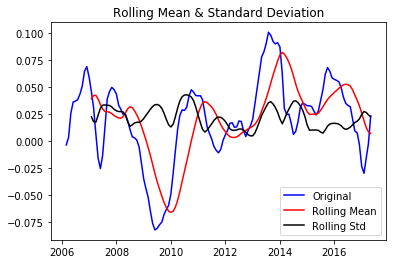

Results of Dickey-Fuller Test:
Test Statistic                  -2.505452
p-value                          0.114153
#Lags Used                       9.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64


In [133]:
moving_avg_tempts_log_diff.dropna(inplace=True)
moving_avg_tempts_log_diff.head()
test_stationarity(moving_avg_tempts_log_diff)

The test statistics is still greater than the critical values

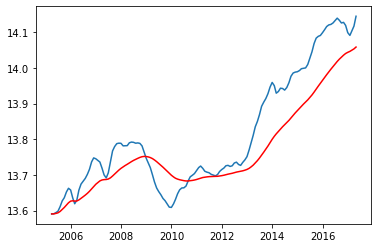

In [134]:
expwt_avg = tempts_log.ewm(halflife=12).mean()
plt.plot(tempts_log)
plt.plot(expwt_avg,color ='red');

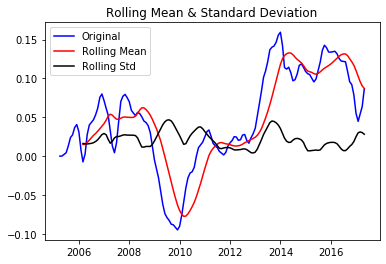

Results of Dickey-Fuller Test:
Test Statistic                  -1.042850
p-value                          0.737317
#Lags Used                      14.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [135]:
tempts_log_expwt_avg_diff = tempts_log - expwt_avg
test_stationarity(tempts_log_expwt_avg_diff)

Both moving average and exponential moving average transformations cannot make the timeseries stationary

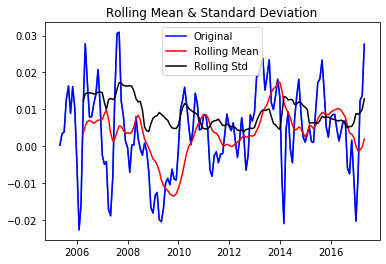

Results of Dickey-Fuller Test:
Test Statistic                  -2.729878
p-value                          0.069009
#Lags Used                      13.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [136]:
# checking for both trend and seasonality
tempts_log_diff = tempts_log - tempts_log.shift()
plt.plot(tempts_log_diff)
tempts_log_diff.dropna(inplace=True)
test_stationarity(tempts_log_diff)

It is stationary because:  
- the mean and std variations have small variations with time.
- test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

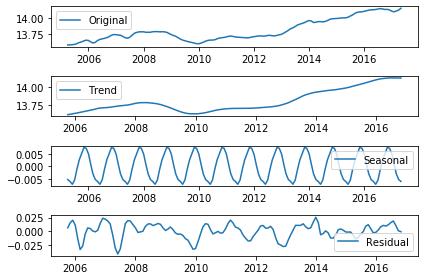

In [137]:
#Using seasonality decomposition to achieve stationarity
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(tempts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tempts_log,label ='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label ='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label ='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label ='Residual')
plt.legend(loc='best')
plt.tight_layout()

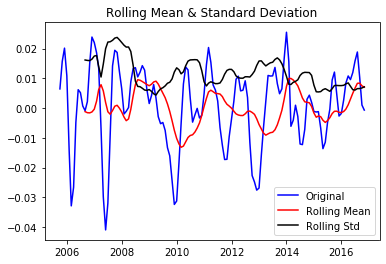

Results of Dickey-Fuller Test:
Test Statistic                  -3.967534
p-value                          0.001590
#Lags Used                      13.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [138]:
tempts_log_decompose = residual
tempts_log_decompose.dropna(inplace=True)
test_stationarity(tempts_log_decompose)

This is stationary because:
- test statistic is lower than 1% critical values.
- the mean and std variations have small variations with time.

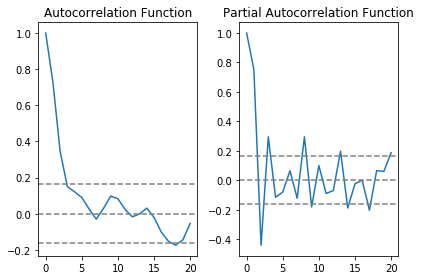

In [139]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(tempts_log_diff,nlags = 20)
lag_pacf = pacf(tempts_log_diff,nlags = 20,method = 'ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle = '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tempts_log_diff)),linestyle = '--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tempts_log_diff)),linestyle = '--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle = '--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tempts_log_diff)),linestyle = '--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tempts_log_diff)),linestyle = '--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:
- p: The first time where the PACF crosses the upper confidence interval, here its close to 3. hence p = 2.
- q: The first time where the ACF crosses the upper confidence interval, here its close to 1. hence q = 1.

In [148]:
from datetime import date
from datetime import datetime
date2 = datetime.strptime('2019-07', '%Y-%m')
date2

datetime.datetime(2019, 7, 1, 0, 0)

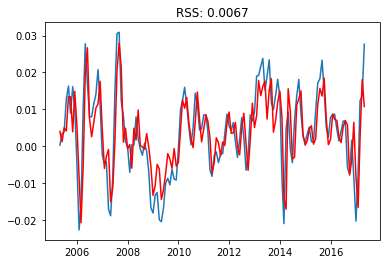

In [140]:
# AR model

modelAR = ARIMA(tempts_log,order =(2,1,0))
results_AR = modelAR.fit(disp=-1,start_ar_lags=13)
plt.plot(tempts_log_diff)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-tempts_log_diff)**2));

#model1 = ARIMA(tempts,order =(2,1,2))
#results_ARIMA1 = model1.fit(disp=-1,start_ar_lags=13)

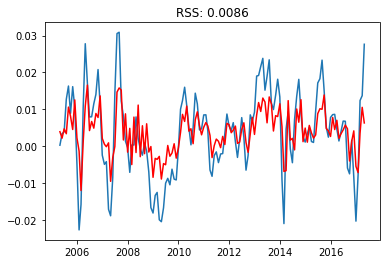

In [141]:
#MA Model
modelMA = ARIMA(tempts_log,order =(0,1,1))
results_MA = modelMA.fit(disp=-1,start_ar_lags=13)
plt.plot(tempts_log_diff)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues-tempts_log_diff)**2));

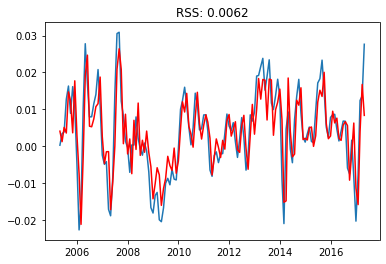

In [143]:
#ARIMA model
modelARIMA = ARIMA(tempts_log,order =(2,1,1))
results_ARIMA = modelARIMA.fit(disp=-1,start_ar_lags=13)
plt.plot(tempts_log_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-tempts_log_diff)**2));

We can see the ARIMA model has the lowest value of RSS and thus we will choose p = 2 and q = 1